### Context

People usually avoid going to the doctor for symptoms that might indicate or more serious virus infection (symptoms such as cold, sneezing, and fever), and prefer taking some normal medicines like paracetamol. Such medicines won’t cure the diseases, and if not treated in time, it can be dangerous for the patient. at the same time, medical experts might take some time to diagnose the patient by analysis of medical images and scans. To help provide people with more quick diagnoses of the disease, we built a Deep learning model that can diagnose with relative accuracy whether the patient has a disease or not, from a set of chest ray images of the patient.

Machine Learning Models in general are powerful tools that can help in rendering medical diagnoses. and automating the process for diagnosing the patient without any effort from field experts.

**Project:** Disease Diagnosis 

**Problem Type:** Image Multi-Classification / Image Recogntiion

## 1- Imports

In [1]:
import os, shutil
from os import walk
import math 
import copy
import time
from PIL import Image
import random
import shutil
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import save_image

import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torchvision.transforms.functional as TF
import torch.optim as optim # optimzer
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.autograd import Variable
from torchvision import models 

from PIL import ImageFile

C:\Users\modaj\anaconda3\envs\DL-torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting time variable (for unique naming)
ts = datetime.datetime.now().timestamp()
print("timestamp:-", ts)

timestamp:- 1664554387.738657


## 2- Data

### 2.1 Checking Train and Test Directories

here we view the general structure of the data provided from the kaggle competition. we see that there generally three classes we are dealing with (covid, normal, virus)

In [3]:
image_paths = {}
file_counts = {}

for (dirpath, dirnames, filenames) in walk("../Data/raw_data/"):
    if len(dirnames) == 0:
        # image_paths[dirpath] = dirpath.replace('\\', '/')
        file_counts[dirpath] = len([entry for entry in os.listdir(dirpath) if os.path.isfile(os.
                                                                path.join(dirpath, entry))])
print("File Counts")
print(file_counts)
print()

File Counts
{'../Data/raw_data/test': 513, '../Data/raw_data/train\\covid': 205, '../Data/raw_data/train\\normal': 328, '../Data/raw_data/train\\virus': 304, '../Data/raw_data/val\\covid': 90, '../Data/raw_data/val\\normal': 140, '../Data/raw_data/val\\virus': 129}



**NOTE** we count the number of files in each of the class directories class directories, in order to compute the relative fraction of files we need to get from each category to make the validation dataset, as we'll see down below in code.

In [4]:
# Image Categories
classes = ('covid', 'normal', 'virus')

### 2.2 Moving Files From Train to Val (30% of files)

We make the validation dataset using 30% of train data. which means 30% of each fraction computed by class_frac, in order to make a dataset with the same distribution as the train dataset.

In [ ]:
class_frac = {}
class_file_count = {}

for dirr in file_counts.keys():
    if 'train' in dirr:
        class_frac[dirr.split('\\')[-1]] = file_counts[dirr]

total_train_files = sum(class_frac.values())
val_test_data = round(0.3 * total_train_files)
for category in class_frac.keys():
    frac = round(class_frac[category]/total_train_files, 2)
    class_frac[category] = frac
    class_file_count[category] = round(frac * val_test_data)
print(f'class fractions: {class_frac}' )
print(f'class file counts: {class_file_count}')

In [ ]:
tr_main_path = '../Data/raw_data/train'
dst_main_path = '../Data/raw_data/val'

for dirr in class_file_count.keys():
    path = os.path.join(tr_main_path, dirr)
    dst_path = os.path.join(dst_main_path, dirr)
    
    print(f'directory: {dirr}')
    for i in range(class_file_count[dirr]):
        rand_file = random.choice(os.listdir(path))

        file_path = os.path.join(path, rand_file).replace('\\', '/')
        dst_file_path = os.path.join(dst_path, rand_file).replace('\\', '/')
        print(f'from "{file_path}" to "{dst_file_path}"')
        shutil.move(file_path, dst_file_path)
    print('-' * 50)

### 2.3 Augmenting Train Data

We apply various image augmentation techniques to the train dataset, this helps in expanding our data, since the data we have generally is rather limited in quantity, and to also guarantee better model training on the images by providing various aspects and settings that improve model performance.

Some of the techniques applied are:
- Horizontal/Vertical Flip
- Rotation
- Grayscale
- Blur/Noise
- Brightness and Contrast

In [5]:
# helper functions
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [6]:
# # tensor conversion + normalization(range:[-1,1])
dataset_list = {}
imageW = 200
imageH = 150

transform = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.ToTensor(), 
     transforms.RandomHorizontalFlip(p=0.5), 
     transforms.RandomVerticalFlip(p=0.5),  
     transforms.Grayscale()])

transform2 = transforms.Compose( 
    [transforms.RandomRotation(degrees=30),
     transforms.Resize((imageW, imageH)),
     transforms.ToTensor()]
)

transform3 = transforms.Compose( 
    [transforms.RandomRotation(degrees=15),
     transforms.Resize((imageW, imageH)),
     transforms.Grayscale(),
     transforms.ToTensor()]
)

transform4 =  transforms.Compose( 
    [transforms.GaussianBlur(kernel_size=(51, 91), sigma=2),
     transforms.Resize((imageW, imageH)),
     transforms.ToTensor()]
)

transform5 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.ToTensor()]
)

transform6 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
      transforms.RandomHorizontalFlip(p=0.5), 
      transforms.RandomVerticalFlip(p=0.5),  
     transforms.ToTensor()]
)

transform7 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.RandomVerticalFlip(p=0.8),  
     transforms.ToTensor()]
)

transform8 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.RandomHorizontalFlip(p=0.2), 
     transforms.RandomVerticalFlip(p=0.2),  
     transforms.ToTensor()]
)
transform9 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.RandomHorizontalFlip(p=0.2), 
     transforms.RandomVerticalFlip(p=0.2),  
     transforms.ToTensor()]
)



dataset = datasets.ImageFolder('../Data/raw_data/train/', transform=transform)
dataset_list['grayscale'] = dataset

dataset2 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform2)
dataset_list['rotation_1'] = dataset2

dataset3 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform3)
dataset_list['rotation_2_grayscale'] = dataset3

dataset4 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform4)
dataset_list['blur'] = dataset4

dataset5 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform5)
dataset_list['noise'] = dataset5

dataset6 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform6)
dataset_list['flip_1'] = dataset6

dataset7 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform7)
dataset_list['flip_2'] = dataset7

dataset8 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform8)
dataset_list['brightness'] = dataset8

dataset9 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform9)
dataset_list['contrast'] = dataset9


print(f"Number of Datasets Made: {len(dataset_list)}")

Number of Datasets Made: 9


In [ ]:
# saving augmented data to Data/data_augmented directory
for i, data_set in enumerate(dataset_list.values()):
    class_mappings = data_set.classes
    print(f'dataset {i+1}')
    print('classes: ', class_mappings)
    for img_index, data in enumerate(data_set):
        tens, label = data
        sub_dir = class_mappings[label]
        
        if i == 3:
            tens = add_noise(tens, noise_factor=0.2) 
        # if i == 7:
        #     tens = TF.adjust_brightness(tens, brightness_factor=1.2)
        # if i == 8:
        #     tens = TF.adjust_contrast(tens, contrast_factor=1.5)
            
        save_image(tens, f'../Data/data_augmented/train/{sub_dir}/img_{i+1}_{img_index+1}_{ts}.png')
    break
#         if img_index > 4:
#             break
        
    print('-' * 30)

### 2.4 Loading Augmented Data and Validation/Test Data

Data is generally split into train and val directory. train directory is applied with image augmentation techniques to create a larger and more versatile dataset. while val directory is split into validation set and test set, one utilized in model training, and the other for final evaluation of the model.

Splits: 
- 70% / 30% --> train / val
- of the 30% val, it is further split: 
    - 67% / 33% --> val / test

We load image data with ImageFolder, which allows us to load image data and transform it to appropriate format, while also defining the labels of the data through the directory structure in "../Data/raw_data/train"

In [7]:
# transformations for when loading data
simple_transform = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.ToTensor()])  

# load data + applying simple transformations
main_dataset = datasets.ImageFolder('../Data/data_augmented/train/', transform=simple_transform)
val_dataset = datasets.ImageFolder('../Data/raw_data/val/', transform=simple_transform)

# data loader parameters
test_frac = 0.33
shuffle_dataset = True
tr_dataset_size = len(main_dataset)
val_dataset_size = len(val_dataset) 
indices = list(range(val_dataset_size))
test_split_1 = int(np.floor(test_frac * val_dataset_size))
random_seed= 42
batch_size = 10

# making splits for test and validation
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
test_indices, val_indices = indices[: test_split_1], indices[test_split_1: ] 
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define Data Loader Objects
dataloader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=test_sampler)

In [8]:
tr_dataset_size = len(main_dataset)
val_dataset_size = len(indices[test_split_1: ])
te_dataset_size = len(indices[: test_split_1])
tr_dataset_size, val_dataset_size, te_dataset_size

(7533, 241, 118)

**NOTE** We use num_workers because it allows us to speed up the training process by utilizing machines with multiple cores.


**NOTE** DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

## 3- Show Images

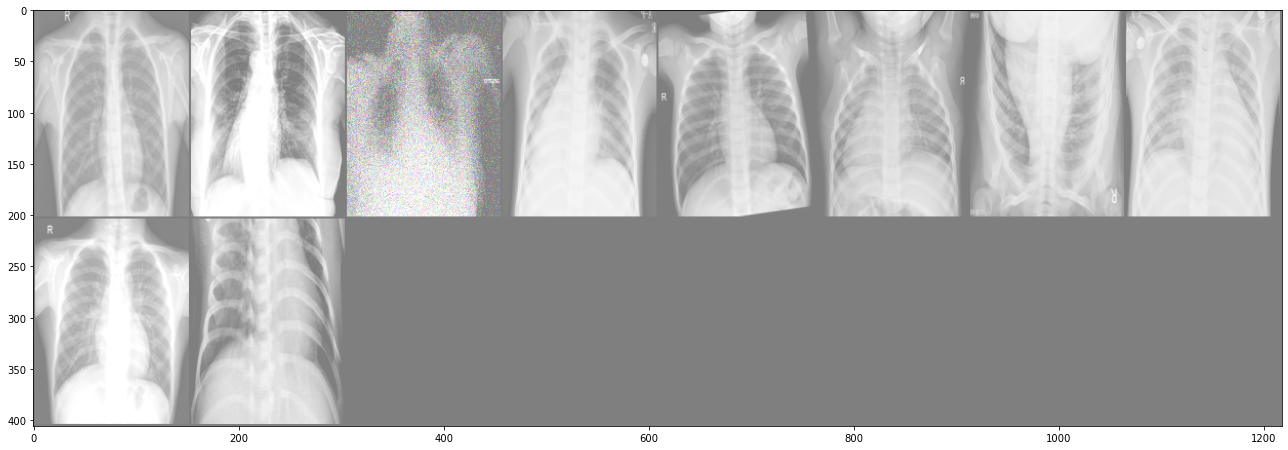

Image Types: ('covid', 'normal', 'virus')


In [9]:
def imshow(img):
    ''' function to show image '''
    img = img / 2 + 0.5 # unnormalize
    npimg = img.data.numpy() # convert to numpy objects
    fig, ax = plt.subplots(figsize=(18, 10))
    # ax.imshow(random.rand(8, 90), interpolation='nearest')
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

# get random training images with iter function
dataiter = iter(dataloader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# # print the class of the image
print(f"Image Types: {classes}")

## 4- Model Definition

### 4.1 Model 1

- Baseline Model
- Structure: 
    - Conv Layer -> Max Pool -> Conv Layer -> Max pool -> flatten(fc1) -> fc2 -> fc3
- Loss: CrossEntropy
    - One popular loss function used for multi-class classification problems
- Optimizer: SGD 
    - simple optimizer used initially before changing into other types of optimizers
- Shows only the final loss value 
- general test accuracy across different experiments: 89% - 93%

In [ ]:
# Defining CNN Model
class Net(nn.Module):
    # Network Initialisation
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 157 *117, 120) # 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, np.prod(x.shape[1:]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.2 Model 2

- Model with bigger, more complex architecture 
- More organized structure and parameterization
- 5 convolution layers with max pooling, 3 fully connected layers, dropout layer for regularization
- Loss: Negative log likelihood aggregate -> log_softmax value (best results)
- Optimizer: Adam (best results)
    - learning rate decay applied
- Confgiures model weights with best results of scores and loss on validation set
- Stores epoch-by-epoch loss and score values
- General test accuracy across different experiments: 91% - 96%

In [ ]:
# helper functions 
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [ ]:
# defined Parameters (Net2)
Net2_params_model = {
    "shape_in": (3, imageW, imageH), 
    "initial_filters": 8,    
    "num_fc1": 400,
    "dropout_rate": 0.25,
    "num_classes": 3
}

In [ ]:
class Net2(nn.Module):
    # Network Initialisation
    def __init__(self, params):
        super(Net2, self).__init__()
        
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv5)
        self.num_flatten=h*w*16*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self,X):
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X));X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X));X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv5(X));X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, self.num_flatten)
        # Flattened Layers (Fully-Connected Layers)
        X = F.relu(self.fc1(X))
        X= F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
    
net = Net2(Net2_params_model)
print(net)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = net.to(device)

In [ ]:
# defining loss function and optimizer
# choice 1
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# choice 2
criterion = nn.NLLLoss(reduction="sum")
optimizer = optim.Adam(net.parameters(), lr=3e-4)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20, verbose=1)

**NOTE** (lr_scheduler) Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.

### 4.3 Model 3 (pretrained)

- Transfer Learning with vgg16 pretrained model 
    - vgg16 is considered to be one of the best computer vision models
    - able to classify 1000 images of 1000 different categories with 92.7% accuracy
- Loss: Cross Entropy (best results)
- Optimizer: SGD (best results, more generalizable model)
    - learning rate decay applied
- Stores epoch-by-epoch loss and score values
- General test accuracy across different experiments: 96% - 99%
- last fc layer is removed and replaced by a layer we are training
    - other layer of pretrained model are frozen

The VGG-16 is able to classify 1000 different labels; we just need 3 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 3 output features instead of 1000.

In [10]:
# vgg16 = models.vgg16_bn()
# vgg16.load_state_dict(torch.load("../Pretrained/vgg16_bn.pth"))
vgg16 = models.vgg16()
vgg16.load_state_dict(torch.load("../Pretrained/vgg16.pth"))
print(vgg16.classifier[6].out_features) # 1000 

1000


In [11]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [12]:
# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer

# features.extend([nn.Linear(num_features, 500)]) # Add our layer with 4 outputs
# features.extend([nn.ReLU(inplace=True)]) 
# features.extend([nn.Dropout(p=0.3, inplace=False)]) 
# features.extend([nn.Linear(500, 100)]) # Add our layer with 4 outputs
# features.extend([nn.ReLU(inplace=True)]) 
# features.extend([nn.Dropout(p=0.1, inplace=False)]) 
# features.extend([nn.Linear(100, 3)])
# features.extend([nn.Linear(500, 100)])
# features.extend([nn.Linear(100, len(classes))])

features.extend([nn.Linear(num_features, len(classes))])

vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../Pretrained/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

In [14]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

# choice 1
criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# choice 2
# criterion = nn.NLLLoss(reduction="sum")
# optimizer = optim.Adam(vgg16.parameters(), lr=3e-4)
# lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20, verbose=1)

In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cnn_model = vgg16.to(device)

## 5- Model Training

### 5.1 Model 1

Settings (across different experiments):
- epochs: 20-150
- batch size: 32-128
- image size: 32 x 24 -> 640 x 480

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
num_epochs = 50
ImageFile.LOAD_TRUNCATED_IMAGES = True

start.record()

for epoch in range(num_epochs):
    print(f'epoch: {epoch}')

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0): 
        # loop to enumerate over the batches from dataloader starting from index = 0
        
        inputs, labels = data

        # parameter initialization (gradients to zero) 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # mini-batch size is 2000
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

**NOTE** we can use **torch.cuda.Event** if we are using a GPU powered training since cuda operations are asynchronous

In [ ]:
# # save
# PATH = '../Results/CNN_torch_model.pth'
# torch.save(net.state_dict(), PATH)

# # reload
# net = Net()
# net.load_state_dict(torch.load(PATH))

### 5.2 Model 2

Settings (across different experiments):
- epochs: 20-100
- batch size: 32-128
- image size: 320 x 240 -> 640 x 480

In [ ]:
## helper functions

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, check=False, opt=None):
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

        # break the loop in case of sanity check
        if check is True:
            break
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [ ]:
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    check=params["check"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    # main loop
    for epoch in range(epochs):
        print('-' * 70)
        # print(f'epoch {epoch+1}')
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        ''' Train the Model on the Training Set '''
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,check,opt)

        ''' Collect loss and metric for training dataset ''' 
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        ''' Evaluate model on validation dataset '''
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model, loss_func, val_dl,check)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f + 30}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [ ]:
# defined paramters for training
Model2_params_train = {
    "train": dataloader, "val": valloader,
    "epochs": 50,
    "optimiser": optimizer,
    "lr_change": lr_scheduler,
    "f_loss": criterion,
    "weight_path": "../Results/Model_Weights/2-moh-torch-model-4-weights.pt",
    "check": False, 
}

In [ ]:
# train and validate the model
cnn_model, loss_hist, metric_hist = train_val(net, Model2_params_train, verbose=True)

#### Train-Validation Progress

In [ ]:
epochs = Model2_params_train["epochs"]

fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["train"],name='loss_hist["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["val"],name='loss_hist["val"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["train"],name='metric_hist["train"]'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["val"],name='metric_hist["val"]'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

### 5.3 Model 3 (pretrained)

Settings (across different experiments): 
- epochs: 10-30
- batch size: 10-14
- image size: 200 x 150
- **issue**: overfitting 

In [20]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloader)
    val_batches = len(valloader)
    loss_history={"train": [],"val": []} 
    metric_history={"train": [],"val": []}  
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloader):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / tr_dataset_size
        avg_acc = acc_train * 2 / tr_dataset_size
        loss_history["train"].append(avg_loss)
        metric_history["train"].append(avg_acc.item())

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(valloader):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / val_dataset_size
        avg_acc_val = acc_val / val_dataset_size
        loss_history["val"].append(avg_loss_val)
        metric_history["val"].append(avg_acc_val.item())

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg, loss_history, metric_history

In [21]:
# clearning cache from gpu for saving memory when allocating GPU memory while training
torch.cuda.empty_cache()
import gc
gc.collect()

170

In [22]:
# checking GPU resources
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  525400 KB |  525400 KB |  525400 KB |       0 B  |
|       from large pool |  524288 KB |  524288 KB |  524288 KB |       0 B  |
|       from small pool |    1112 KB |    1112 KB |    1112 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  525400 KB |  525400 KB |  525400 KB |       0 B  |
|       from large pool |  524288 KB |  524288 KB |  524288 KB |

In [24]:
num_epochs= 15
vgg16, loss_hist_vgg16, metric_hist_vgg16 = train_model(vgg16, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
torch.save(vgg16.state_dict(), '../Pretrained/VGG16_v2-disease-detection-2.pt')

Epoch 0/15
----------
Training batch 300/377.0
Validation batch 0/25

C:\Users\modaj\AppData\Local\Temp\ipykernel_153172\3550218769.py:74: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Epoch 0 result: 
Avg loss (train): 0.0267
Avg acc (train): 0.9019
Avg loss (val): 0.0222
Avg acc (val): 0.9170
----------

Epoch 1/15
----------
Training batch 300/377.0
Validation batch 0/25
Epoch 1 result: 
Avg loss (train): 0.0134
Avg acc (train): 0.9547
Avg loss (val): 0.0234
Avg acc (val): 0.9253
----------

Epoch 2/15
----------
Training batch 300/377.0
Validation batch 0/25
Epoch 2 result: 
Avg loss (train): 0.0107
Avg acc (train): 0.9624
Avg loss (val): 0.0217
Avg acc (val): 0.9544
----------

Epoch 3/15
----------
Training batch 300/377.0
Validation batch 0/25
Epoch 3 result: 
Avg loss (train): 0.0069
Avg acc (train): 0.9765
Avg loss (val): 0.0198
Avg acc (val): 0.9544
----------

Epoch 4/15
----------
Training batch 300/377.0
Validation batch 0/25
Epoch 4 result: 
Avg loss (train): 0.0050
Avg acc (train): 0.9823
Avg loss (val): 0.0169
Avg acc (val): 0.9627
----------

Epoch 5/15
----------
Training batch 300/377.0
Validation batch 0/25
Epoch 5 result: 
Avg loss (train): 0.00

In [27]:
cnn_model = vgg16

#### Train-Validation Progress

In [28]:
# epochs = Model2_params_train["epochs"]
epochs = num_epochs

fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist_vgg16["train"],name='loss_hist["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist_vgg16["val"],name='loss_hist["val"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist_vgg16["train"],name='metric_hist["train"]'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist_vgg16["val"],name='metric_hist["val"]'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

## 6- Model Evaluation

### 6.1 Test on Sample data

test 1


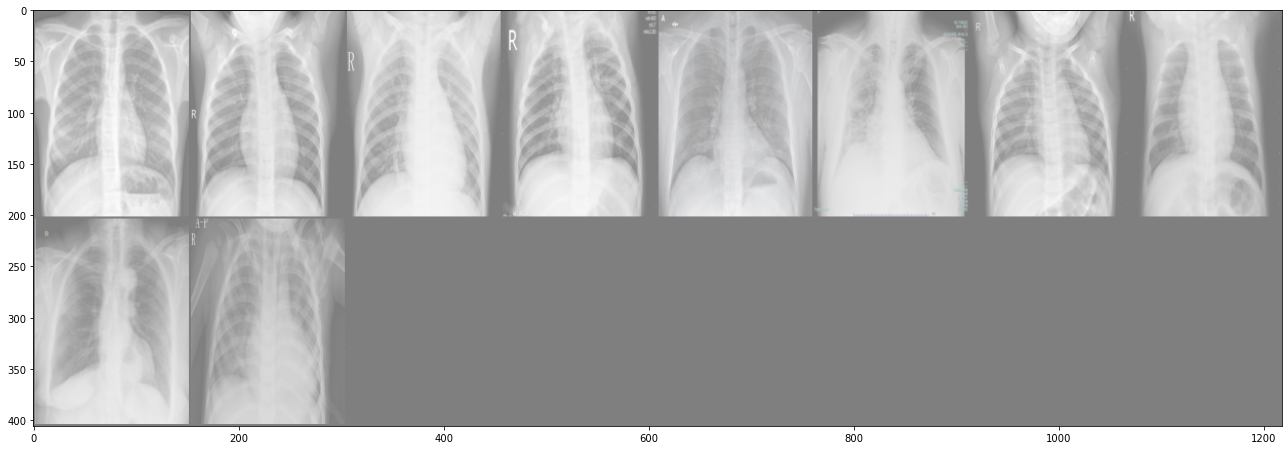

GroundTruth:  normal normal virus virus covid covid normal virus covid virus
Predicted:  normal normal virus virus covid covid normal virus covid virus
----------------------------------------------------------------------------------------------------

test 2


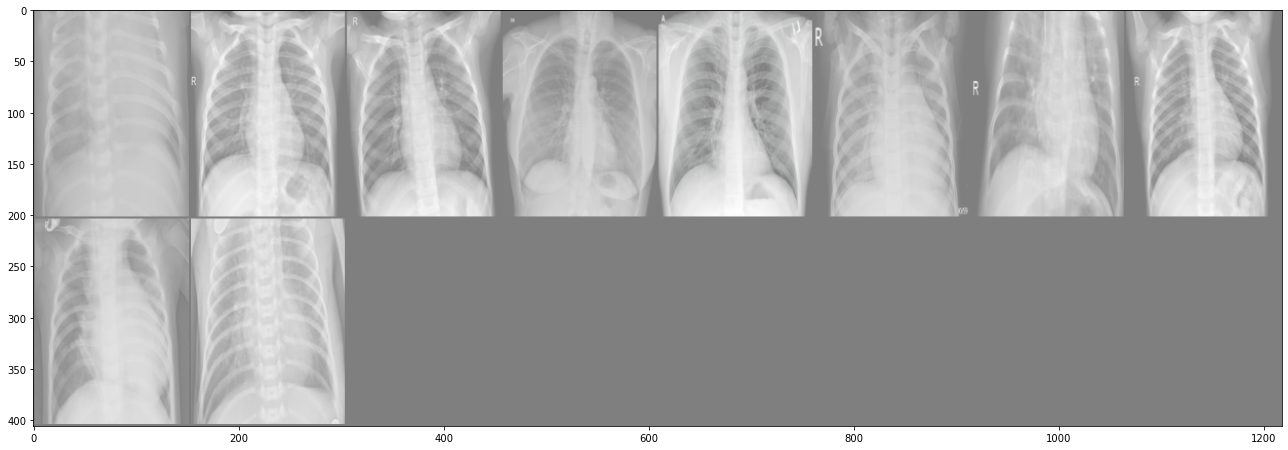

GroundTruth:  virus normal normal covid covid virus virus normal virus virus
Predicted:  virus normal normal covid covid virus virus normal virus virus
----------------------------------------------------------------------------------------------------

test 3


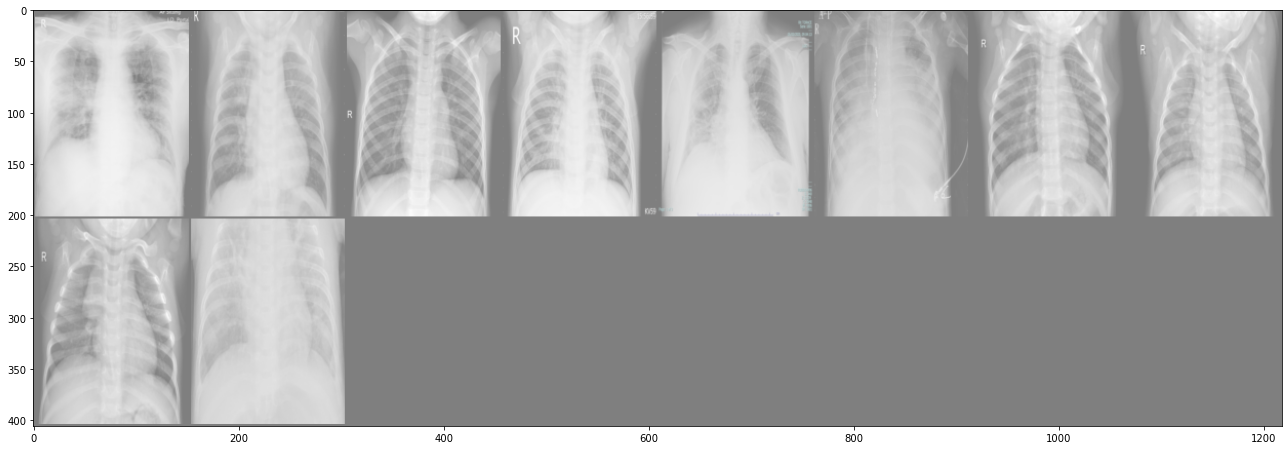

GroundTruth:  covid virus normal virus covid virus normal normal normal virus
Predicted:  covid virus normal virus covid virus normal normal normal virus
----------------------------------------------------------------------------------------------------

test 4


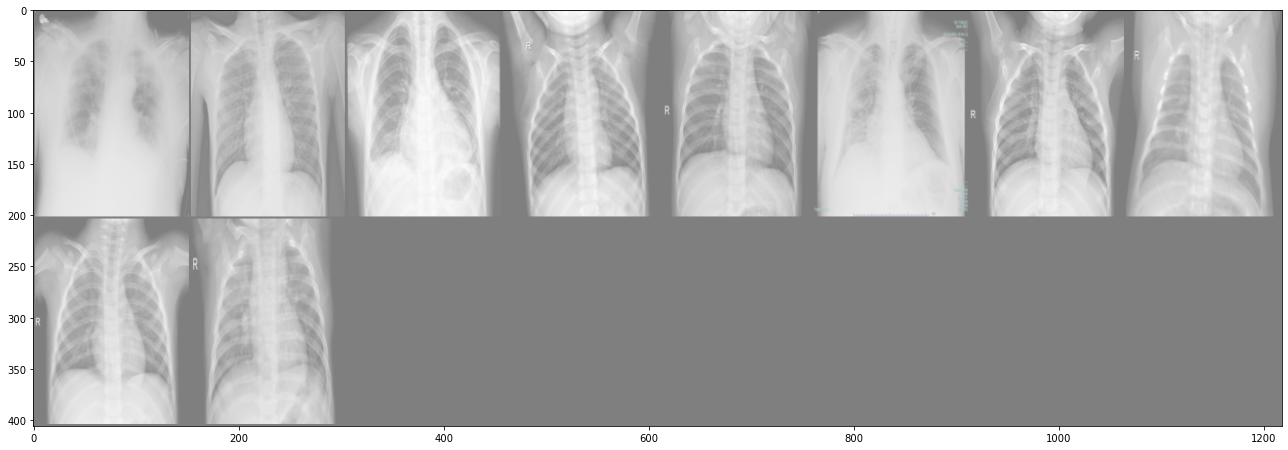

GroundTruth:  covid covid virus normal normal covid normal normal normal virus
Predicted:  covid normal virus normal normal covid normal normal normal virus
----------------------------------------------------------------------------------------------------

test 5


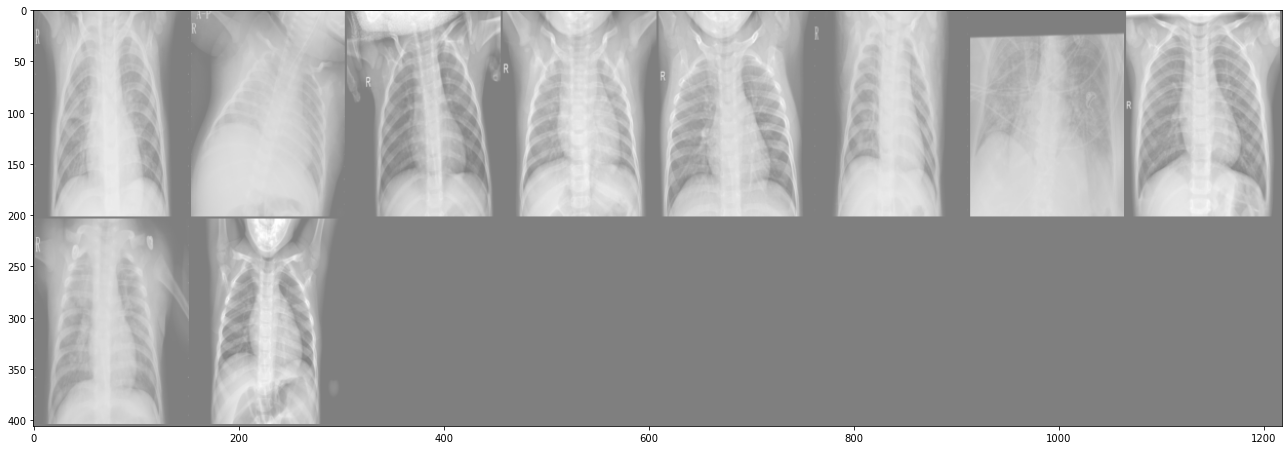

GroundTruth:  virus virus normal normal normal virus covid normal virus normal
Predicted:  virus virus virus virus normal virus covid normal virus normal
----------------------------------------------------------------------------------------------------



In [33]:
# print images
dataiter = iter(testloader)
for test in range(5):
    print('test {}'.format(test+1))
    images, labels = dataiter.next()
    images = images.cpu()
    labels = labels.cpu()
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(len(images))))
    outputs = cnn_model(images.cuda())
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                                  for j in range(len(images))))
    print('-' * 100, end='\n\n')

### 6.2 Model Accuracy

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        print('labels ', labels.cpu().numpy())
        print('predictions ', predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

labels  [1 2 0 1 1 1 2 2 1 2]
predictions  [1 2 0 1 1 1 2 2 1 2]

labels  [2 1 1 0 1 1 0 0 2 2]
predictions  [2 2 2 1 1 1 0 0 2 2]

labels  [0 1 1 1 1 0 1 0 1 1]
predictions  [0 1 1 1 1 0 1 0 1 1]

labels  [0 2 0 1 0 2 2 2 1 2]
predictions  [0 2 0 1 0 2 2 2 1 1]

labels  [0 2 1 1 2 2 0 1 0 2]
predictions  [0 2 1 1 2 2 0 2 0 2]

labels  [0 2 2 1 1 2 1 2 1 0]
predictions  [0 2 2 1 1 2 1 2 1 0]

labels  [0 2 0 1 0 2 1 0 2 2]
predictions  [0 2 0 1 0 2 1 0 2 2]

labels  [2 2 2 1 1 0 1 1 2 1]
predictions  [2 2 2 1 1 0 1 1 2 1]

labels  [0 0 1 0 2 2 2 0 1 1]
predictions  [0 0 1 0 2 2 2 0 1 1]

labels  [0 1 2 0 0 1 1 0 1 2]
predictions  [0 1 2 0 0 2 2 0 1 2]

labels  [2 2 1 1 1 0 2 0 1 1]
predictions  [2 2 1 1 1 0 2 0 1 1]

labels  [1 0 1 1 2 0 0 2]
predictions  [1 0 1 1 2 0 0 2]

Accuracy of the network on the test images: 94 %


In [45]:
print('Pytorch (Baseline): 90% accuracy')
print('Pytorch (100 epochs): 89% accuracy')
print('Pytorch (higher resolution): 91% accuracy')
print('Pytorch (higher batch size): 90% accuracy')
print('Pytorch (image augmentation (replace data)): 87-89% accuracy')
print('Pytorch (image augmentation (add to data, 5x data)): 94% accuracy')
print('Pytorch (image augmentation (add to data, 5x data), higher resolution): 93%-94% accuracy')
print('Pytorch (image augmentation (add to data, 5x data), higher resolution, bigger batch, smaller test split): 93% accuracy')
print('Pytorch (image augmentation (add to data, 5x data), validation/test split, different model architecture): 96% accuracy')
print('vgg16 pretrained model 1 (3 layers, non-augmented data): 98%')
print('vgg16 pretrained model 2 (3 layers, augmented data): 99%')
print('vgg16 pretrained model 2 (1 layer, augmented data): 99%')

Pytorch (Baseline): 90% accuracy
Pytorch (100 epochs): 89% accuracy
Pytorch (higher resolution): 91% accuracy
Pytorch (higher batch size): 90% accuracy
Pytorch (image augmentation (replace data)): 87-89% accuracy
Pytorch (image augmentation (add to data, 5x data)): 94% accuracy
Pytorch (image augmentation (add to data, 5x data), higher resolution): 93%-94% accuracy
Pytorch (image augmentation (add to data, 5x data), higher resolution, bigger batch, smaller test split): 93% accuracy
Pytorch (image augmentation (add to data, 5x data), validation/test split, different model architecture): 96% accuracy
vgg16 pretrained model 1 (3 layers, non-augmented data): 98%
vgg16 pretrained model 2 (3 layers, augmented data): 99%
vgg16 pretrained model 2 (1 layer, augmented data): 99%


### 6.3 Inference on Submission Data

In [46]:
rootpath = '../Data/raw_data/test'
paths = []
for subdir, dirs, files in walk(rootpath):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        paths.append(filepath)

class TestDataset(Dataset):
    def __init__(self):
        images_processed = []
        self.imagelist = paths
        
    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, index):
        self.imagepath = self.imagelist[index]
        self.image = Image.open(self.imagepath)
        self.image = self.image.convert("RGB")
        
        transform = transforms.Compose( 
            [transforms.Resize((imageW, imageH)),
             transforms.ToTensor()])
        
        # Note: transform already defined above
        i = transform(self.image)
        images_processed.append(self.imagepath.replace('\\', '/'))
        return i


submission_dataset = TestDataset()
submloader = torch.utils.data.DataLoader(submission_dataset, batch_size=32)

In [47]:
num_images = 0
images_processed = []
all_predictions = []

for batch_num, images in enumerate(submloader):
    print(f'batch {batch_num + 1} ({len(images)} images)')
    images = images.to(device)
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)
    predictions = [classes[predicted[j]] for j in range(len(images))]
    all_predictions.extend(predictions)
    print('Predicted:', ' '.join(predictions))
    print()
print('-' * 50)
    
print(f'number of images processed: {len(images_processed)}')
print(f'number of images predicted: {len(all_predictions)}')

batch 1 (32 images)
Predicted: covid virus covid normal virus virus covid covid virus virus normal virus normal normal covid virus covid normal normal covid virus covid covid virus normal virus virus covid virus virus virus covid

batch 2 (32 images)
Predicted: virus normal virus covid virus covid covid virus covid normal covid covid virus normal covid normal virus covid virus virus covid covid normal virus covid normal virus normal covid covid covid normal

batch 3 (32 images)
Predicted: virus virus virus virus virus normal virus covid covid covid covid virus covid normal covid covid normal covid normal covid covid virus virus normal normal virus normal covid normal normal virus virus

batch 4 (32 images)
Predicted: normal covid virus normal virus normal covid normal normal covid covid normal normal covid virus covid normal virus covid virus normal covid virus normal normal virus normal normal virus normal virus covid

batch 5 (32 images)
Predicted: virus covid virus covid normal norm

In [48]:
image_names = list(map(lambda x: x.split('/')[-1], images_processed))
results_df = pd.DataFrame(list(zip(image_names, all_predictions)),
               columns =['Image', 'Label'])
results_df

Image   Label
0       040263.jpeg   covid
1      0621724.jpeg   virus
2      0777738.jpeg   covid
3     10256151.jpeg  normal
4    105615245.jpeg   virus
..              ...     ...
508    93490032.jpg   covid
509   93559118.jpeg  normal
510   98633775.jpeg   covid
511   98777712.jpeg   virus
512    9947263.jpeg   virus

[513 rows x 2 columns]

In [49]:
results_df.to_csv('../Results/Submissions/torch-vgg16-results-2.csv', index=False)

### References
- https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data
- https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
- https://discuss.pytorch.org/t/load-big-amount-of-unlabeled-images-and-predict-classes/132443
- https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be
- https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658
- https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification
- https://discuss.pytorch.org/t/images-not-read-properly-anymore-after-an-epoch-of-successful-training/92586
- https://stackoverflow.com/questions/59201907/overfitting-on-image-classification
- https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch/data?select=vgg16.pth
- https://pytorch.org/vision/stable/transforms.html